## 可以画出每次serving data 和training data DDLA的分布

In [77]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn import tree
import pydotplus
from subprocess import check_call
from graphviz_sql.extract import to_sql 
import sqlite3
import pickle
from scipy import stats
import sys
import argparse
import pickle
from scipy import stats
import sys
import argparse
import os
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import time

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [79]:
def find_distributions(model, data):
    X_test = data[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']]
    y_test = data[["price"]]
    y_predict = model.predict(X_test)
    y_test_DT = y_test.reset_index()
    y_predict_DT = pd.DataFrame(y_predict, columns = ['predict'])
    data_M2 = pd.concat([y_test_DT, y_predict_DT], axis=1, join='inner')
    data_M2['result'] = np.where(data_M2["price"]==data_M2['predict'],'0','1')
    data_M2.set_index(["index"], inplace=True)
    data_M2 = pd.concat([data_M2, X_test], axis=1, join='inner')
    
    x_DT = data_M2[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']]
    y_DT = data_M2[["result"]]
    X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(x_DT, y_DT, test_size=0.5, random_state=42)
    ### SMOTE
    # y_train_DT = y_train_DT.astype('int')
    # oversample = SMOTE(random_state=42)
    # X_balance_DT,Y_balance_DT = oversample.fit_resample(X_train_DT,y_train_DT)
    # X_balance_DT = pd.DataFrame(X_balance_DT, columns = X_train_DT.columns)
    #train Decision tree
    model_DT = DecisionTreeClassifier(max_depth=8,
                                      min_samples_split=20,
                                      random_state=42
                               )
    model_DT.fit(X_train_DT, y_train_DT)
    y_test_DT = y_test_DT.astype('int')
    y_predict_DT = model_DT.predict(X_test_DT)
    
    ##save DT tree plan dot
    dot_data=tree.export_graphviz(model_DT, out_file='/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot', feature_names= x_DT.columns,
                               class_names=['0', '1'], node_ids=True,
                              filled=True, rounded=True,  
                              special_characters=True)
    check_call(['dot','-Tpng','/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot','-o','/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_CatBoost_3.png'])
    ##save sql doc
    to_sql('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.dot', '/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql')
    
    X_test['predict'] = y_predict
    X_test['result'] = np.where(y_test['price']==X_test['predict'],'0','1')
    data_result = X_test
    data_result['team'] = 0
    df = data_result
    #connect to a database
    conn = sqlite3.connect("pipleine_ourM3.db") #if the db does not exist, this creates a Any_Database_Name.db file in the current directory
    #store your table in the database:
    df.to_sql('Some_Table_Name', conn)
    #read a SQL Query out of your database and into a pandas dataframe
    sql_string = 'SELECT * FROM Some_Table_Name'
    df = pd.read_sql(sql_string, conn)
    # Open and read the file as a single buffer
    fd = open('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql', 'r')
    sqlFile = fd.read()
    fd.close()
    ## prepare sql document
    sqlFile=sqlFile.replace('select case', 'UPDATE Some_Table_Name \nSET team = \nCASE')
    n=sqlFile.count('then 0 ')

    sqlFile = sqlFile.replace('then 0 ', 'then -xxx')
    for i in range(n):
        sqlFile = sqlFile.replace('-xxx', str(-i), 1)

    m=sqlFile.count('then 1 ')
    sqlFile = sqlFile.replace('then 1 ', 'then +xxx')
    for i in range(m):
        sqlFile = sqlFile.replace('+xxx', str(i+1), 1)
    fd = open('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql', 'w+')
    fd.write(sqlFile)
    fd.close()

    ## compile sql doc
    sql_string = sqlFile.split(';')
    cur = conn.cursor()
    for command in sql_string:
        cur.execute(command)
    os.remove("pipleine_ourM3.db")
    ##read data from database
    sql_string='SELECT * FROM Some_Table_Name;'
    df = pd.read_sql(sql_string, conn)
    df1= df.team.value_counts()
    df1.to_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_team_count_pepiline.csv")    
    g = df.groupby("team")
    m=g['result'].value_counts(normalize=True,sort=False)
    acc=m.loc[-400:400,'0']
    acc=acc.to_frame()
    acc.to_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_acc_result_pipeline.csv")    
    df1=pd.read_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_team_count_pepiline.csv")
    df1.set_index(["Unnamed: 0"], inplace=True)
    df1 = df1.rename_axis('Team_number')
    df1 = df1.rename(columns={'team': 'account'})
    acc = pd.read_csv("/Users/sdong/phd_doc/att/Fraud/data/Black_box_acc_result_pipeline.csv")
    acc=acc[['team','result.1']]
    acc.set_index(["team"], inplace=True)
    acc = acc.rename_axis('Team_number')
    acc = acc.rename(columns={'result.1': 'Accuracy'})
    List_accuracy = pd.concat([acc, df1], axis=1, join='inner')
    accuracy_team=List_accuracy.reset_index()
    
    #low_accuracy_teams=low_accuracy_teams.reset_index() 
    accuracy_team['percentage']= accuracy_team['account']/X_test['bedrooms'].count()
    # low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < 0.7741]
#     X = low_accuracy_teams['Team_number']
#     y = low_accuracy_teams['percentage']

#     # 创建柱状图
#     plt.bar(X, y)

#     # 设置 X 轴和 Y 轴标签
            

#     # 显示图形
#     plt.show()

    return accuracy_team
    


In [80]:
# 定义检测函数
from scipy.stats import ks_2samp
def drift_detection(X_train, X_test, threshold=0.05):
    """
    检测数据分布是否漂移
    """
    # 提取特征列表
    features = X_train.columns.tolist()

    # 初始化检测结果列表
    results = []

    # 针对每个特征，计算p-value和KS统计量
    for feature in features:
        # 获取训练数据和测试数据中的该特征的值
        train_values = X_train[feature].values
        test_values = X_test[feature].values

        # 计算KS统计量和p-value
        ks_statistic, p_value = ks_2samp(train_values, test_values)

        # 判断是否漂移
        if p_value < threshold:
            drift = True
        else:
            drift = False

        # 记录检测结果
        results.append({
            "feature": feature,
            "p_value": p_value,
            "ks_statistic": ks_statistic,
            "drift": drift
        })
        
    is_drift = any([result["drift"] for result in results])
        
    # 返回结果列表
    return is_drift

In [81]:
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist
def mmd_fast(X, Y, sigma=None):
    """
    高斯核的MMD值计算函数，使用Nystrom方法加速计算
    X: ndarray, shape (n_samples_X, n_features)
    Y: ndarray, shape (n_samples_Y, n_features)
    sigma: float, 高斯核的带宽参数
    """
    X=X.values
    Y=Y.values
    n_samples_X, n_samples_Y = X.shape[0], Y.shape[0]

    # 计算高斯核矩阵
    K_XX = rbf_kernel(X, X, gamma=1/(2*sigma**2)) if n_samples_X <= 5000 else rbf_kernel(X[:5000], X[:5000], gamma=1/(2*sigma**2))
    K_YY = rbf_kernel(Y, Y, gamma=1/(2*sigma**2)) if n_samples_Y <= 5000 else rbf_kernel(Y[:5000], Y[:5000], gamma=1/(2*sigma**2))
    K_XY = rbf_kernel(X, Y, gamma=1/(2*sigma**2)) if n_samples_X <= 5000 and n_samples_Y <= 5000 else rbf_kernel(X[:5000], Y[:5000], gamma=1/(2*sigma**2))

    # 计算MMD值
    mmd = (np.sum(K_XX) / (n_samples_X * (n_samples_X - 1)) + np.sum(K_YY) / (n_samples_Y * (n_samples_Y - 1)) - 2 * np.sum(K_XY) / (n_samples_X * n_samples_Y))
    
    # 根据MMD值判断是否存在数据漂移
    is_drift_mmd=False
    if mmd > 0.001:
        is_drift_mmd=True
    return is_drift_mmd

In [82]:
####  H-D
join=os.path.join
from sklearn.decomposition import PCA
# parser = argparse.ArgumentParser()

# parser.add_argument('--n', type=int, default=300)
# parser.add_argument('--seed', type=int, default=1)
# parser.add_argument('--log_dir', type=str, default='logs')
# parser.add_argument('--runs', type=int, default=1)

n=200
seed=1
log_dir='logs'
runs=1
bandwidth = 'scott'
max_data_size = n
# args = parser.parse_args()

np.random.seed(seed)

def get_kde_estimates(bandwidth, data) :
	# kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
	data = data.T
	kernel = stats.gaussian_kde(data, bandwidth)
	return kernel.evaluate(data)




if not os.path.exists(log_dir):
	os.makedirs(log_dir)




fname = join(log_dir, 'result_' + str(max_data_size) + '.txt')

def in_top_k(scores, k):
    indices = np.argsort(scores)[::-1]
    pos = np.where(indices==0)[0][0]
    print(f"pos:{pos}")
    return pos <= k

def evaluate(data_1,data_2):
    scores = []
    data1 = data_1.sample(n=200,  random_state=42).to_numpy()
    data2 = data_2.to_numpy()
  
    for rep in range(100):

        if rep != 0:
            data_all = np.concatenate([data1, data2], axis=0)
            data_all = data_all[np.random.permutation(range(data_all.shape[0]))]
            data1 = data_all[:max_data_size]
            data2 = data_all[max_data_size:]
        datam = np.concatenate([data1[:max_data_size//2], data2[:max_data_size//2]], axis=0)
        pca = PCA(n_components=5)
        # 将13维数组X降维到4维
        data1 = pca.fit_transform(data1)
        data2 = pca.fit_transform(data2)
        datam = pca.fit_transform(datam)
        logprob_1 = get_kde_estimates(bandwidth, data1)
        logprob_2 = get_kde_estimates(bandwidth, data2)
        logprob_m = get_kde_estimates(bandwidth, datam)

        vdiv = np.mean(-logprob_m) - min(np.mean(-logprob_1), np.mean(-logprob_2))
        with open(fname, 'a') as f:
            f.write("Scores " + str(np.mean(logprob_1)) + " " + str(np.mean(logprob_2)) + " " + str(np.mean(logprob_m)) + "\n")
        scores.append(vdiv)

    return in_top_k(scores, k=90)





In [83]:
# 读取数据集到dataframe
df_all = pd.read_csv("/Users/sdong/phd_doc/dataset/kc_house_data.csv")
#df_all = df_all[["type","amount","oldbalanceOrg","newbalanceOrig","isFraud"]]
#df_oslo = pd.read_csv('/Users/sdong/phd_doc/att/weather_data/oslo_data.csv')
# df_all = df_all.rename(columns={
#     'age': 'age',
#     'workclass': 'workclass',
#     'fnlwgt': 'fnlwgt',
#     'education': 'education',
#     'education.num': 'education_num',
#     'marital.status': 'marital',
#     'occupation': 'occupation',
#     'relationship': 'relationship',
#     'capital.gain': 'capital_gain',
#     'capital.loss': 'capital_loss',
#     'hours.per.week': 'hours_week',
#     'native.country': 'country',
#     'income': 'income',
#     'race': 'race',
#     'sex': 'sex'
# })
# df_all[df_all == '?'] = np.nan
# for col in ['workclass', 'occupation', 'country']:
#     df_all[col].fillna(df_all[col].mode()[0], inplace=True)
df_all.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [84]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
plt.title('Price Distribuition')
sns.distplot(df_all['price'])

plt.subplot(122)
g1 = plt.scatter(range(df_all.shape[0]), np.sort(df_all.price.values))
g1= plt.title("Price Curve Distribuition", fontsize=15)
g1 = plt.xlabel("")
g1 = plt.ylabel("Amount(US)", fontsize=12)

plt.subplots_adjust(wspace = 0.3, hspace = 0.5,
                    top = 0.9)
plt.show()

In [85]:
print("Price Min")
print(df_all['price'].min())
print("Price Mean")
print(df_all['price'].mean())
print("Price Median")
print(df_all['price'].median())
print("Price Max")
print(df_all['price'].max())
print("Price Std")
print(df_all['price'].std())

Price Min
75000.0
Price Mean
540088.1417665294
Price Median
450000.0
Price Max
7700000.0
Price Std
367127.1964826997


In [86]:
# create a new column 'label' based on the price column
df_all['price'] = df_all['price'].apply(lambda x: True if x > 540088 else False)

In [87]:
# 按照“yr_built”进行排序
df_all = df_all.sort_values("yr_built")
df_all.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4697,9126101645,20140610T000000,True,4,2.00,2180,3870,1.0,0,0,...,7,1020,1160,1900,0,98122,47.6089,-122.303,1520,2580
2961,1947300115,20140619T000000,False,3,1.00,1320,3625,2.0,0,0,...,7,1320,0,1900,0,98122,47.6049,-122.288,1660,5438
12369,9138100350,20150218T000000,True,4,2.00,2290,6000,1.5,0,3,...,7,2290,0,1900,0,98115,47.6807,-122.318,2000,3150
15016,1703400585,20141215T000000,False,3,2.00,2330,4950,1.5,0,0,...,6,1430,900,1900,0,98118,47.5585,-122.290,1160,5115
5236,844000425,20141223T000000,False,3,1.00,960,10815,1.0,0,0,...,5,960,0,1900,0,98010,47.3091,-122.006,1330,10815
8732,3364900156,20150317T000000,False,1,1.00,620,2380,1.0,0,0,...,6,620,0,1900,0,98115,47.6746,-122.326,980,3570
14001,2354300456,20150311T000000,False,2,1.00,600,1500,1.0,0,0,...,4,600,0,1900,0,98027,47.5289,-122.033,1130,6000
17182,7883601155,20140530T000000,False,3,2.00,1330,6000,1.0,0,0,...,7,630,700,1900,0,98108,47.5255,-122.327,1140,6000
3131,9829200590,20141028T000000,True,3,2.75,1960,6390,1.5,0,2,...,8,1960,0,1900,0,98122,47.6032,-122.285,2440,5870
498,9274202270,20140818T000000,True,2,1.50,1490,5750,1.5,0,0,...,7,1190,300,1900,0,98116,47.5872,-122.390,1590,4025


In [88]:
print("yr_built Min")
print(df_all['yr_built'].min())
print("yr_built Mean")
print(df_all['yr_built'].mean())
print("yr_built Median")
print(df_all['yr_built'].median())
print("yr_built Max")
print(df_all['yr_built'].max())
print("yr_built Std")
print(df_all['yr_built'].std())

yr_built Min
1900
yr_built Mean
1971.0051357978994
yr_built Median
1975.0
yr_built Max
2015
yr_built Std
29.37341080239461


In [89]:
df_all = df_all.drop(columns=["id","date"])
print(df_all.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [90]:
df_all.to_csv("/Users/sdong/phd_doc/dataset/house_prepare.csv", index=False)

In [91]:
print(df_all.info())
df_all.head()
# df_all.race.value_counts()
# df_all.sex.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 4697 to 14489
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  bool   
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqf

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4697,True,4,2.0,2180,3870,1.0,0,0,3,7,1020,1160,1900,0,98122,47.6089,-122.303,1520,2580
2961,False,3,1.0,1320,3625,2.0,0,0,3,7,1320,0,1900,0,98122,47.6049,-122.288,1660,5438
12369,True,4,2.0,2290,6000,1.5,0,3,5,7,2290,0,1900,0,98115,47.6807,-122.318,2000,3150
15016,False,3,2.0,2330,4950,1.5,0,0,3,6,1430,900,1900,0,98118,47.5585,-122.290,1160,5115
5236,False,3,1.0,960,10815,1.0,0,0,5,5,960,0,1900,0,98010,47.3091,-122.006,1330,10815


In [92]:
# 将 yr_built 在 1900 到 1919 之间的数据作为训练集，其他数据作为服务集
train_set = df_all[(df_all['yr_built'] >= 1900) & (df_all['yr_built'] <= 1929)]
test_set = df_all[(df_all['yr_built'] < 1900) |(df_all['yr_built'] > 1929)]

# 打印训练集和测试集的行数
print('Train set rows:', len(train_set))
print('Test set rows:', len(test_set))


Train set rows: 2643
Test set rows: 18970


In [93]:
print(train_set.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [94]:
# 查看 adult.income 列的值计数
income_counts = train_set['price'].value_counts()

# 打印值计数
print(income_counts)

False    1360
True     1283
Name: price, dtype: int64


In [95]:
x = train_set.drop(columns=["price"])
y = train_set[["price"]]

# splitting the data
X_train_ML, X_test_ML, y_train_ML, y_test_ML = train_test_split(x, y, test_size=0.5, random_state=42)

from imblearn.over_sampling import SMOTE
y_train_ML = y_train_ML.astype('int')
oversample = SMOTE(random_state=42)
X_balance_ML,Y_balance_ML = oversample.fit_resample(X_train_ML,y_train_ML)
X_balance_ML = pd.DataFrame(X_balance_ML, columns = X_train_ML.columns)

Epoch 1/10
42/42 [==============================] - 0s 4ms/step - loss: 4822.8389 - accuracy: 0.4981 - val_loss: 362.0703 - val_accuracy: 0.6036
Epoch 2/10
42/42 [==============================] - 0s 2ms/step - loss: 170.5526 - accuracy: 0.6268 - val_loss: 305.5600 - val_accuracy: 0.6634
Epoch 3/10
42/42 [==============================] - 0s 2ms/step - loss: 74.5457 - accuracy: 0.7033 - val_loss: 273.2317 - val_accuracy: 0.5923
Epoch 4/10
42/42 [==============================] - 0s 2ms/step - loss: 54.3287 - accuracy: 0.7101 - val_loss: 178.3378 - val_accuracy: 0.7504
Epoch 5/10
42/42 [==============================] - 0s 2ms/step - loss: 40.9048 - accuracy: 0.7313 - val_loss: 132.6305 - val_accuracy: 0.7617
Epoch 6/10
42/42 [==============================] - 0s 2ms/step - loss: 31.5008 - accuracy: 0.7494 - val_loss: 111.8427 - val_accuracy: 0.7708
Epoch 7/10
42/42 [==============================] - 0s 2ms/step - loss: 31.1348 - accuracy: 0.7411 - val_loss: 90.5488 - val_accuracy: 0.77

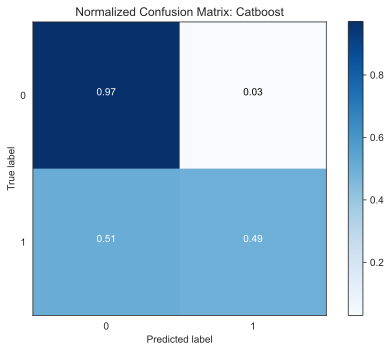

In [96]:
from xgboost import XGBClassifier
# model = LogisticRegression(C=0.1,
#                        random_state=42,
#                        solver='lbfgs')
###### LightGBM
# model = LGBMClassifier(num_leaves=31,
#                        max_depth=5, 
#                        learning_rate=0.02,
#                        n_estimators=100,
#                        subsample = 0.8,
#                        colsample_bytree =0.8
#                       )
# model = CatBoostClassifier(iterations=150,
#                            learning_rate=0.2,
#                            od_type='Iter',
#                            verbose=25,
#                            depth=16,
#                            random_seed=42)
# model = RandomForestClassifier(n_estimators=250,
#                       max_depth=12,
#                       min_samples_leaf=16,
#                                random_state=42
#                      )

#########XGBOOST
# model = XGBClassifier(max_depth=6,
#               n_estimators=100,
#               min_child_weight=8, 
#               subsample=0.8, 
#               learning_rate =0.02,    
#               seed=42)
# model = svm.SVC( C=10,random_state=42)


#####################
from keras.models import Sequential
from keras.layers import Dense

# 构建神经网络模型
model = Sequential()
# model.add(Dense(64, activation='relu', input_dim=14))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

from keras.layers import Dropout
from keras import regularizers



# 添加Dropout层和L1/L2正则化
model.add(Dense(32, activation='relu', input_dim=18 ))
#model.add(Dropout(0.5))
model.add(Dense(32, activation='relu' ))
#model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# #model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


# model.add(Dense(128, activation='relu', input_dim=14))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.add(Dense(128, activation='relu', input_dim=14))
# model.add(Dense(1, activation='sigmoid'))

#     # 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from keras.callbacks import EarlyStopping

# 创建EarlyStopping回调
early_stop = EarlyStopping(monitor='val_loss', patience=3)
# #     # 训练模型
#     model.fit(X_balance_ML, Y_balance_ML, epochs=10, validation_data=(X_test_ML, y_test_ML))
# 在模型训练时使用EarlyStopping回调
#model.fit(X_balance_ML, Y_balance_ML, epochs=10, validation_data=(X_test_ML, y_test_ML), callbacks=[early_stop])
model.fit(X_train_ML, y_train_ML,epochs=10, validation_data=(X_test_ML, y_test_ML))
y_predict = model.predict(X_test_ML)
y_predict = (y_predict > 0.5).astype(int)
acc_tre=accuracy_score(y_test_ML, y_predict)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test_ML, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test_ML,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test_ML,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: Catboost')



In [97]:
import joblib
import pickle
    
filename = "/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib"
joblib.dump(model, filename)

INFO:tensorflow:Assets written to: ram://10619532-2412-4e1f-842c-e08b4c1cf40a/assets


['/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib']

In [98]:
data_test = pd.concat([X_test_ML, y_test_ML], axis=1, join='inner')
#data_test.info()
accuracy_team = find_distributions(model, data_test)
print(accuracy_team)



42/42 [==============================] - 0s 549us/step
...
=====wrirte sql success======
    Team_number  Accuracy  account  percentage
0           -15  0.962264      159    0.120272
1           -14  0.700000       10    0.007564
2           -13  0.838710       31    0.023449
3           -12  0.500000       10    0.007564
4           -11  0.928571       56    0.042360
5           -10  0.642857       42    0.031770
6            -9  0.903226       31    0.023449
7            -8  0.888889       54    0.040847
8            -7  0.714286       14    0.010590
9            -6  0.500000        2    0.001513
10           -5  0.979592       49    0.037065
11           -4  0.875000        8    0.006051
12           -3  0.875000       32    0.024206
13           -2  0.976048      167    0.126324
14           -1  0.921569      102    0.077156
15            0  0.800000        5    0.003782
16            1  0.750000        4    0.003026
17            3  0.250000        4    0.003026
18            4  0

In [99]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

In [100]:
x_budapest = test_set.drop(columns=["price"])
y_budapest = test_set['price']


y_predict_budapest = model.predict(x_budapest)
y_predict_budapest = (y_predict_budapest > 0.5).astype(int)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_budapest, y_predict_budapest)))
print(pd.DataFrame(confusion_matrix(y_budapest,y_predict_budapest)))




593/593 [==============================] - 0s 408us/step
CatBoost Accuracy Score is 0.74918
       0     1
0  10477  1857
1   2901  3735


In [76]:
# y_budapest = y_budapest.reset_index()
# y_predict_budapest = pd.DataFrame(y_predict_budapest, columns = ['predict'])

# data_budapest = pd.concat([y_budapest, y_predict_budapest], axis=1, join='inner')
# data_budapest['result'] = np.where(data_budapest['isFraud']==data_budapest['predict'],'0','1')
# data_budapest.set_index(["index"], inplace=True)
# data_budapest = pd.concat([data_budapest, x_budapest], axis=1, join='inner')
# data_budapest_0 = data_budapest[data_budapest['result'] == "0"]
# data_budapest_0 = data_budapest_0.sample(frac=0.05, random_state=42)
# data_budapest_1 = data_budapest[data_budapest['result'] == "1"]
# data_budapest = pd.concat([data_budapest_0, data_budapest_1], axis=0)
# data_budapest = data_budapest.sample(frac=1, random_state=42)
# x_budapest = data_budapest.drop(columns=["isFraud","predict","result"])
# y_budapest = data_budapest.drop(columns=["type", "amount", "oldbalanceOrg", "newbalanceOrig","predict","result"])

# y_predict_budapest = model.predict(x_budapest)
# print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_budapest, y_predict_budapest)))
# print(pd.DataFrame(confusion_matrix(y_budapest,y_predict_budapest)))

# df_budapest=data_budapest[["isFraud","type", "amount", "oldbalanceOrg", "newbalanceOrig"]]

## Our DDLA

In [51]:
import pandas as pd
import sqlite3
import os
import time
drift_samples_df_1= test_set

drift_samples_df= train_set

new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')
PDDLA_Increase_count = 0
bad_drift_count=0
detect_right=0
AL_labeled_number=0
final_accuracy_list = []
accuracy_sample_list = []
accuracy_sample_list_2 = []
is_drift_KS_list = []
bad_drift_list = []
PDDLA_Increase_list = []
is_drift_mmd_list = []
is_drift_hd_list=[]

Number_AL=[]
trainingtime_list=[]
#os.remove("pipleine_ourM3.db")
#low_acc_teams=0

# 对每个样本添加新的列
thre_acc = acc_tre
batch_size = 200
num_batches = 90

for i in range(num_batches):
    # start_index = (i+80) * batch_size
    # end_index = start_index + batch_size
    # sample = drift_samples_df_1[start_index:end_index]
    # # 读取样本数据
    sample = drift_samples_df_1.sample(n=batch_size,  replace=True, random_state=42
                                      )
        #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(sample.index)
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #sample = drift_samples_df_1.sample(n=500, replace=False, random_state=42+i)
    #print(sample)
    # 添加新的列
    
#     ## k-s test result
#     is_drift_KS = drift_detection(new_train_data.drop(columns=["price"]), sample.drop(columns=["price"]))
#     is_drift_KS_list.append(is_drift_KS)
    
#     ## MMD test result
#     sigma = 1
#     is_drift_mmd = mmd_fast(new_train_data.drop(columns=["price"]), sample.drop(columns=["price"]), sigma=sigma)
#     is_drift_mmd_list.append(is_drift_mmd)
    
    # H-D test result
    # 检测数据分布是否漂移
#     is_drift_hd = evaluate(new_train_data.drop(columns=["income"]), sample.drop(columns=["income"]))
#     is_drift_hd_list.append(is_drift_hd)
    
    y_predict_sample = model.predict(sample.drop(columns=["price"]))
    y_predict_sample = (y_predict_sample > 0.5).astype(int)
    y_sample = sample[["price"]]
    accuracy_sample = accuracy_score(y_sample, y_predict_sample)
    sample["team"] =  0
    df = sample 
    Number_AL.append(0)
    

    #connect to a database
    conn = sqlite3.connect("sample_pipeline5.db") #if the db does not exist, this creates a Any_Database_Name.db file in the current directory
    #store your table in the database:
    df.to_sql('Some_Table_Name', conn)   
    # Open and read the file as a single buffer
    fd = open('/Users/sdong/phd_doc/att/Fraud/image/tree_DT_Interpretable_pipeline_test.sql', 'r')
    sqlFile = fd.read()
    fd.close()
    from sqlite3 import OperationalError
    sql_string = sqlFile.split(';')
    cur = conn.cursor()
    for command in sql_string:
        cur.execute(command)
    sql_string='SELECT * FROM Some_Table_Name;'
    df = pd.read_sql(sql_string, conn)
    # 关闭数据库连接
    conn.close()
    # 删除数据库文件
    os.remove("sample_pipeline5.db")
    # 将low_accuracy_team数据框按Team_number升序排列
    #low_acc_teams = low_accuracy_teams.sort_values('Team_number')
    #low_acc_teams.reset_index()
    #print(low_acc_teams)
    # 计算包含在low_accuracy_team中的团队的准确率和百分比的乘积
#     team_contributions = []
#     for index, row in accuracy_team.iterrows():
#         team_num = row['Team_number']
#         accuracy = row['Accuracy']
#         team_df = df.loc[df['team'] == team_num]
#         team_percentage = len(team_df) / len(df)
        
#         team_contribution = accuracy * team_percentage
#         team_contributions.append(team_contribution)

    # # 计算不包含在low_accuracy_team中的团队的准确率和百分比的乘积
    # other_df = df.loc[~df['team'].isin(low_accuracy_teams['Team_number'].tolist())]
    # other_percentage = len(other_df) / len(df)
    # other_contribution = 0.94 * other_percentage

    # 将两部分相加以获得最终的准确率
    # final_accuracy = sum(team_contributions)
    #print(f"The {i} our Accuracy: {final_accuracy}, real acc: {accuracy_sample}")
    print(f"The {i} batch serving data real acc: {accuracy_sample}")
    
    low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < thre_acc]
    
    low_accuracy_teams_2 = low_accuracy_teams.copy()  # 复制数据框以避免更改原始数据框
    low_accuracy_teams_2['percentage'] = 0

    for index, row in low_accuracy_teams.iterrows():
        team_num = row['Team_number']
        team_df = df.loc[df['team'] == team_num]
        team_percentage = len(team_df) / len(df)

        low_accuracy_teams_2.at[index, 'percentage'] = team_percentage  # 修改 low_accuracy_teams_2 中相应团队的百分比值



    # print(f"low_accuracy_teams")
    # print(low_accuracy_teams) 
    # print(f"low_accuracy_teams_2")
    # print(low_accuracy_teams_2)
    # print(f"low_accuracy_teams_value1")
    # print(low_accuracy_teams.iloc[0]['Team_number'])
    
    
    
    
    #######################################################
    # drow pecentage data drift in training and serving data
    # 设置柱状图参数
    
#     print(f"the {i} batch serving data's drift figure")
#     bar_width = 0.35
#     opacity = 0.8

#     # 绘制两个数据集的柱状图
#     plt.bar(low_accuracy_teams['Team_number'], low_accuracy_teams['percentage'], bar_width, alpha=opacity, color='b', label='Training data')
#     plt.bar(low_accuracy_teams_2['Team_number'] + bar_width, low_accuracy_teams_2['percentage'], bar_width, alpha=opacity, color='g', label='Serving data')

#     # 设置X轴和Y轴标签
#     plt.xlabel('DDLA ID')
#     plt.ylabel('Percentage of DDLA')

#     # 设置图例
#     plt.legend()

#     # 显示图形
#     plt.show()
    ##################################
    team_numbers = []
    team_numbers_2 = []
    
    
 

    for n in range(len(low_accuracy_teams)):
        if low_accuracy_teams.iloc[n]['Team_number'] == low_accuracy_teams_2.iloc[n]['Team_number']:
            percentage_change = low_accuracy_teams_2.iloc[n]['percentage'] - low_accuracy_teams.iloc[n]['percentage']
            if percentage_change > 0 and percentage_change >= low_accuracy_teams.iloc[n]['percentage'] * 0.1 and low_accuracy_teams_2.iloc[n]['percentage']> 0.05:
            #and percentage_change >= low_accuracy_teams.iloc[n]['percentage'] * 0.1 and low_accuracy_teams_2.iloc[n]['percentage']> 0.01:
                team_numbers.append(low_accuracy_teams.iloc[n]['Team_number'])

    #print(team_numbers)
    
    team_numbers_2 = low_accuracy_teams['Team_number']
    #print(team_numbers_2)
    ##################
    
    #final_accuracy_list.append(final_accuracy)
    accuracy_sample_list.append(accuracy_sample)
    accuracy_sample_list_2.append(accuracy_sample)
    trainingtime_list.append(0)    
    if len(team_numbers):
        print(f"The {i} retrain")
        PDDLA_Increase_count += 1
        PDDLA_Increase_list.append(True)
        

            

        # 重新训练模型
        #if accuracy_sample < 0.95*0.948:
        #print(len(df))
        sample_df = df[df['team'].isin(team_numbers_2)]
        print(len(sample_df))
        
        Number_AL.pop()
        Number_AL.append(len(sample_df))
        
        sample_df = sample_df.drop(columns=['index'])
        sample_df= sample_df.drop(columns=["team"])
        # print(sample)
        # print("********************")
        # print(sample_df)
        #print(new_train_data.info())
        #print(sample.info())
        new_train_data = pd.concat([new_train_data, sample_df])
        AL_labeled_number=AL_labeled_number+len(sample_df)
        #print(new_train_data.info())
        # model = LogisticRegression(C=0.8,
        #                random_state=42,
        #                solver='lbfgs')
                ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                        max_depth=5, 
        #                        learning_rate=0.02,
        #                        n_estimators=100,
        #                        subsample = 0.8,
        #                        colsample_bytree =0.8
        #                       )
        # model = CatBoostClassifier(iterations=150,
        #                            learning_rate=0.2,
        #                            od_type='Iter',
        #                            verbose=25,
        #                            depth=16,
        #                            random_seed=42)
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16
        #                       )

        #########XGBOOST
        # model = XGBClassifier(max_depth=6,
        #               n_estimators=100,
        #               min_child_weight=8, 
        #               subsample=0.8, 
        #               learning_rate =0.02,    
        #               seed=42)
        # model = svm.SVC( random_state=42)
        
        x = new_train_data.drop(columns=["price"])
        y = new_train_data[["price"]]
        ##########
        from imblearn.over_sampling import SMOTE
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        
        
        # 记录开始时间
        start_time = time.time()
        model.fit(X_balance_re, Y_balance_re,epochs=10)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list.pop()
        trainingtime_list.append(elapsed_time)
        
        y_predict_sample = model.predict(sample.drop(columns=["price","team"]))
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = sample[["price"]]
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        print(f"The retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
        #new_train_data[["BBQ_weather","DATE","MONTH","cloud_cover","humidity","pressure","global_radiation","precipitation","sunshine","temp_mean","temp_max"]])
        accuracy_team=find_distributions(model, new_train_data)
        
        ### change the thredshord of the accuracy of the DDLA
        y_predict_new_data = model.predict(x)
        y_predict_new_data = (y_predict_new_data > 0.5).astype(int)
        thre_acc = accuracy_score(new_train_data[["price"]], y_predict_new_data)
        print(thre_acc)
        
    else:
        print(f"The {i} No retrain")
        PDDLA_Increase_list.append(False)
        
# print(is_drift_KS_list)            
# print(PDDLA_Increase_list) 


# result_MY_hd= []
# for n in range(len(is_drift_hd_list)): 
#     if is_drift_hd_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_hd.append(1)
#     elif is_drift_hd_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_hd.append(2)
#     elif is_drift_hd_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_hd.append(3)
#     elif is_drift_hd_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_hd.append(4)
# print(f"HD compare with our method result: {pd.value_counts(result_MY_hd)}")

# result_MY_ks= []
# for n in range(len(is_drift_KS_list)): 
#     if is_drift_KS_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_ks.append(1)
#     elif is_drift_KS_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_ks.append(2)
#     elif is_drift_KS_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_ks.append(3)
#     elif is_drift_KS_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_ks.append(4)
# print(f"KS compare with our method result: {pd.value_counts(result_MY_ks)}")

# result_MY_mmd= []
# for n in range(len(is_drift_mmd_list)): 
#     if is_drift_mmd_list[n]==PDDLA_Increase_list[n]==True:
#         result_MY_mmd.append(1)
#     elif is_drift_mmd_list[n]==True and PDDLA_Increase_list[n]==False:
#         result_MY_mmd.append(2)
#     elif is_drift_mmd_list[n]==False and PDDLA_Increase_list[n]==True:
#         result_MY_mmd.append(3)
#     elif is_drift_mmd_list[n]== PDDLA_Increase_list[n]==False:
#         result_MY_mmd.append(4)

    
print(f"our method retrained {PDDLA_Increase_count} times")
print(f"真实共有{bad_drift_count}个样本的准确率低于0.9")
print(f"共有{detect_right}次准确检查出low accuracy data drift")
print(f"一共标记了{AL_labeled_number}次")
accuracy_sample_list_DDLA=accuracy_sample_list
accuracy_sample_list_2_DDLA = accuracy_sample_list_2
average_acc = sum(accuracy_sample_list_2_DDLA) / len(accuracy_sample_list_2_DDLA)
print(f"Average Oue methods: {average_acc}")

7/7 [==============================] - 0s 669us/step
The 0 batch serving data real acc: 0.645
The 0 retrain
105
Epoch 1/10
45/45 [==============================] - 0s 882us/step - loss: 107.9611 - accuracy: 0.5932
Epoch 2/10
45/45 [==============================] - 0s 875us/step - loss: 31.8519 - accuracy: 0.6919
Epoch 3/10
45/45 [==============================] - 0s 876us/step - loss: 21.4098 - accuracy: 0.7225
Epoch 4/10
45/45 [==============================] - 0s 801us/step - loss: 33.2411 - accuracy: 0.6669
Epoch 5/10
45/45 [==============================] - 0s 862us/step - loss: 22.0867 - accuracy: 0.7142
Epoch 6/10
45/45 [==============================] - 0s 765us/step - loss: 36.1797 - accuracy: 0.6690
Epoch 7/10
45/45 [==============================] - 0s 785us/step - loss: 25.9196 - accuracy: 0.7135
Epoch 8/10
45/45 [==============================] - 0s 722us/step - loss: 16.2557 - accuracy: 0.7469
Epoch 9/10
45/45 [==============================] - 0s 771us/step - loss: 17.74

KeyboardInterrupt: 

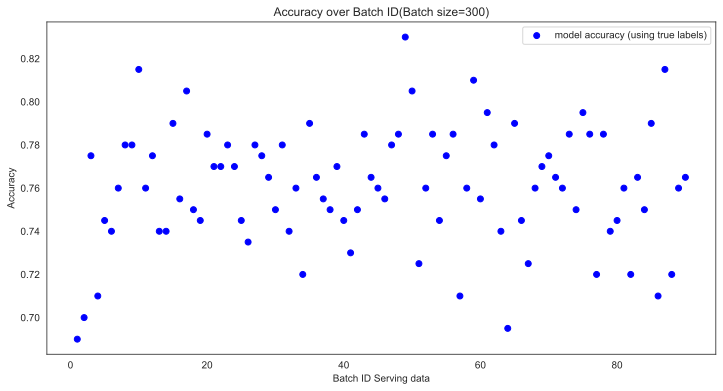

In [167]:
import matplotlib.pyplot as plt

# 设置final_accuracy和accuracy_sample的值，例如这里设置为一些随机值


# 画出折线图，其中x轴为1到5，y轴分别为final_accuracy和accuracy_sample
plt.figure(figsize=(12,6))
#plt.plot(range(1, 51), final_accuracy_list,'o-', color='orange', label='Accuracy_caclulate', alpha=1)
#plt.plot(range(1, 101), accuracy_sample_list, color='green', label='model accuracy (using true labels)',  alpha=0.5)
#plt.scatter(range(1, 101), final_accuracy_list, color='red', label='Accuracy_caclulate')
plt.scatter(range(1, len(accuracy_sample_list)+1), accuracy_sample_list, color='blue', label='model accuracy (using true labels)')
#plt.scatter(range(1, 101), accuracy_sample_list_2, color='blue', label='Retrained real Accuracy points')
#plt.scatter(range(1, 101), accuracy_sample_list, c=['red' if acc < 0.9 else 'none' for acc in accuracy_sample_list], edgecolors='none', label='Points need retrain')
#plt.scatter(range(1, 101), accuracy_sample_list_2, c=['blue' if acc < 0.9 else 'none' for acc in accuracy_sample_list], edgecolors='none', label='Retrained points')

# x = []
# y = []
# for i in range(100):
#     n=i+1
#     if accuracy_sample_list[i] <= 0.9:
#         x.append(n)
#         y.append(accuracy_sample_list[i])
# plt.plot(x, y, 'o-',color='green',  alpha=0.5, label='Points need retrain')

# x = []
# y = []
# for i in range(100):
#     n=i+1
#     if accuracy_sample_list[i] <= 0.9:
#         x.append(n)
#         y.append(accuracy_sample_list_2[i])

# # 将点连接起来
# plt.plot(x, y, 'o-',color='red',  alpha=0.5, label='Retrained points')

# 画阈值线
#plt.axhline(y=0.9, color='red', linestyle='--', label='Threshold')

# 添加图例，横轴和纵轴标签以及标题
plt.legend()
plt.xlabel('Batch ID Serving data')
plt.ylabel('Accuracy')
plt.title('Accuracy over Batch ID(Batch size=300)')

# 显示图像
plt.show()








In [168]:
# plt.figure(figsize=(12,6))
# plt.plot(range(1, 101), accuracy_sample_list_2, color='red', label='accuracy after retrain',  alpha=1)
# #plt.plot(range(1, 101), accuracy_sample_list_2, color='blue', label='accuracy after retrain',  alpha=0.5)
# # 画阈值线
# #plt.axhline(y=0.9, color='red', linestyle='--', label='Threshold')

# x = []
# y = []
# for i in range(100):
#     n=i+1
#     if accuracy_sample_list[i] != accuracy_sample_list_2[i]:
#         x.append(n)
#         y.append(accuracy_sample_list[i])

# # 将点连接起来
# plt.scatter(x, y,color='blue',  alpha=1, label='points need retrain')
# #plt.scatter(range(1, 101), final_accuracy_list, color='red', label='Accuracy_caclulate')

# # 添加图例，横轴和纵轴标签以及标题
# plt.legend()
# plt.xlabel('Batch ID Serving data')
# plt.ylabel('Accuracy')
# plt.title('Accuracy over Batch ID(Batch size=300)')

In [169]:
# count = 0
# for i in range(len(accuracy_sample_list_2)):
#     if accuracy_sample_list_2[i] > accuracy_sample_list[i]:
#         count += 1
# print(f"{count}")

## K_S


In [333]:
# 定义检测函数
def drift_detection(X_train, X_test, threshold=0.05):
    """
    检测数据分布是否漂移
    """
    # 提取特征列表
    features = X_train.columns.tolist()

    # 初始化检测结果列表
    results = []

    # 针对每个特征，计算p-value和KS统计量
    for feature in features:
        # 获取训练数据和测试数据中的该特征的值
        train_values = X_train[feature].values
        test_values = X_test[feature].values

        # 计算KS统计量和p-value
        ks_statistic, p_value = ks_2samp(train_values, test_values)

        # 判断是否漂移
        if p_value < threshold:
            drift = True
        else:
            drift = False

        # 记录检测结果
        results.append({
            "feature": feature,
            "p_value": p_value,
            "ks_statistic": ks_statistic,
            "drift": drift
        })
        

    # 返回结果列表
    return results

In [339]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]
is_drift=0
# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
Number_AL_KS=[]
trainingtime_list_KS=[]
count_retrain_KS=0

# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = (i+80) * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42
                                              )
    #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    Number_AL_KS.append(0)    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    print(f"Sample {i}: Accuracy = {acc:.4f}")
    # print(service_sample)

    
    # 检测数据分布是否漂移
    results = drift_detection(new_train_data.drop(columns=["price"]), X_service)

    # 判断是否漂移
    is_drift = any([result["drift"] for result in results])


    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_KS+=1
        new_train_data = pd.concat([new_train_data, service_sample])
        # print(new_train_data)
        # model = LogisticRegression(C=0.8,
        #                    random_state=42,
        #                    solver='lbfgs')
        ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                        max_depth=5, 
        #                        learning_rate=0.02,
        #                        n_estimators=100,
        #                        subsample = 0.8,
        #                        colsample_bytree =0.8
        #                       )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16,
        #                                random_state=42
        #                       )
        ### XGB
        # model = XGBClassifier(max_depth=6,
        #       n_estimators=100,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)
                
        x = new_train_data.drop(columns=["price"])
        y = new_train_data['price']
        ##########
        from imblearn.over_sampling import SMOTE
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        start_time = time.time()
        model.fit(x, y, epochs=10)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_KS.append(elapsed_time)
        y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = service_sample['price']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        Number_AL_KS.pop()
        Number_AL_KS.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_KS.append(0)   
        
        
accuracy_sample_list_2_KS = accuracy_sample_list_2
print(f'KS retrain {count_retrain_KS} times' )
average_acc_KS = sum(accuracy_sample_list_2_KS) / len(accuracy_sample_list_2_KS)
print(f"Average Oue methods: {average_acc_KS}")

7/7 [==============================] - 0s 817us/step
Sample 0: Accuracy = 0.6400
Epoch 1/10
48/48 [==============================] - 0s 994us/step - loss: 113.6083 - accuracy: 0.6220
Epoch 2/10
48/48 [==============================] - 0s 1ms/step - loss: 49.0081 - accuracy: 0.6634
Epoch 3/10
48/48 [==============================] - 0s 1ms/step - loss: 31.9039 - accuracy: 0.7061
Epoch 4/10
48/48 [==============================] - 0s 1ms/step - loss: 27.2616 - accuracy: 0.6956
Epoch 5/10
48/48 [==============================] - 0s 1ms/step - loss: 30.9165 - accuracy: 0.6778
Epoch 6/10
48/48 [==============================] - 0s 1ms/step - loss: 27.8583 - accuracy: 0.6798
Epoch 7/10
48/48 [==============================] - 0s 1ms/step - loss: 19.8696 - accuracy: 0.7370
Epoch 8/10
48/48 [==============================] - 0s 1ms/step - loss: 44.5779 - accuracy: 0.6154
Epoch 9/10
48/48 [==============================] - 0s 1ms/step - loss: 38.5164 - accuracy: 0.6463
Epoch 10/10
7/7 [========

## MMD

In [340]:

import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

In [341]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics

def mmd_fast(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
        # 根据MMD值判断是否存在数据漂移
    print(f'mmd : {mmd}')
    is_drift_mmd=False
    if mmd > 0.00514:
        is_drift_mmd=True
    return is_drift_mmd

In [342]:
# def mmd_value(X, Y, gamma=1.0):
#     """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

#     Arguments:
#         X {[n_sample1, dim]} -- [X matrix]
#         Y {[n_sample2, dim]} -- [Y matrix]

#     Keyword Arguments:
#         gamma {float} -- [kernel parameter] (default: {1.0})

#     Returns:
#         [scalar] -- [MMD value]
#     """
#     XX = metrics.pairwise.rbf_kernel(X, X, gamma)
#     YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
#     XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
#     mmd = XX.mean() + YY.mean() - 2 * XY.mean()
#         # 根据MMD值判断是否存在数据漂移

#     return mmd

In [343]:
# print(len(train_set))

In [344]:
# drift_samples_df_2= test_set
# drift_samples_df_3= test_set
# mmd_list=[]
# n=1451
# m=200
# for i in range(100):
    
#     # start_index = i * batch_size
#     # end_index = start_index + batch_size
#     # service_sample = drift_samples_df_1[start_index:end_index]
#     service_sample_2 = df_all.sample(n, replace=True)
#     # 在原始 DataFrame 中删除已采样的子集

#     n=n+200
#     service_sample_3 = df_all.sample(m, replace=True)
#     # 在原始 DataFrame 中删除已采样的子集
    
#     mmd = mmd_value(service_sample_2.drop(columns=["price"]), service_sample_3.drop(columns=["price"]))
#     mmd_list.append(mmd)

# print(mmd_list)


In [345]:
# print(np.mean(mmd_list))
# print(min(mmd_list))

In [346]:

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]

# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
Number_AL_MMD=[]
trainingtime_list_MMD=[]
count_retrain_MMD=0

# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = (i+80) * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True,random_state=42)
    # 在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    
    
    Number_AL_MMD.append(0)
    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    print(f"Sample {i}: Accuracy = {acc:.4f}")

    # 检测数据分布是否漂移

    is_drift = mmd_fast(new_train_data.drop(columns=["price"]), service_sample.drop(columns=["price"]))



    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_MMD+=1
        new_train_data = pd.concat([new_train_data, service_sample])
        # model = LogisticRegression(C=0.8,
        #                    random_state=42,
        #                    solver='lbfgs')
                ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                max_depth=5, 
        #                learning_rate=0.02,
        #                n_estimators=100,
        #                subsample = 0.8,
        #                colsample_bytree =0.8
        #               )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16,
        #                     random_state=42
        #                       )

        # model = XGBClassifier(max_depth=6,
        #       n_estimators=100,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)
        x = new_train_data.drop(columns=["price"])
        y = new_train_data['price']
        ##########
        from imblearn.over_sampling import SMOTE
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        start_time = time.time()
        model.fit(x, y,epochs=10)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_MMD.append(elapsed_time)
        ###############
        y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = service_sample['price']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        Number_AL_MMD.pop()
        Number_AL_MMD.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_MMD.append(0)        
        

accuracy_sample_list_MMD=accuracy_sample_list
accuracy_sample_list_2_MMD = accuracy_sample_list_2
print(f'MMD retrain {count_retrain_MMD} times' )

7/7 [==============================] - 0s 4ms/step
Sample 0: Accuracy = 0.6400
mmd : 0.005762732795389908
Epoch 1/10
48/48 [==============================] - 0s 1ms/step - loss: 196.6333 - accuracy: 0.5799
Epoch 2/10
48/48 [==============================] - 0s 950us/step - loss: 22.4917 - accuracy: 0.7383
Epoch 3/10
48/48 [==============================] - 0s 955us/step - loss: 24.5412 - accuracy: 0.6870
Epoch 4/10
48/48 [==============================] - 0s 962us/step - loss: 32.9626 - accuracy: 0.6463
Epoch 5/10
48/48 [==============================] - 0s 975us/step - loss: 22.9367 - accuracy: 0.6917
Epoch 6/10
48/48 [==============================] - 0s 1ms/step - loss: 29.9157 - accuracy: 0.6614
Epoch 7/10
48/48 [==============================] - 0s 1ms/step - loss: 30.2543 - accuracy: 0.6746
Epoch 8/10
48/48 [==============================] - 0s 1ms/step - loss: 28.2712 - accuracy: 0.6555
Epoch 9/10
48/48 [==============================] - 0s 1ms/step - loss: 18.2440 - accuracy: 0

## HD

In [347]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")

In [348]:

drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

# 初始化检测结果列表
drift_results = []
p_value_list = []
is_drift_list=[]

# 初始化检测到漂移的样本列表
drift_samples = []
accuracy_sample_list_2 = []
accuracy_sample_list = []
accuracy_before_retrain = []
Number_AL_HD=[]
trainingtime_list_HD=[]
count_retrain_HD=0
# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size,  replace=True,random_state=42)
    #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)

    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    Number_AL_HD.append(0)    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    
    # 检测数据分布是否漂移
    is_drift = evaluate(new_train_data.drop(columns=["price"]), X_service)
    is_drift_list.append(is_drift)
    
    # 判断是否漂移
    #is_drift = any([result["drift"] for result in results])


    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号
    is_drift_list.append(is_drift)
    if is_drift:
        count_retrain_HD+=1
        new_train_data = pd.concat([new_train_data, service_sample])
        ###### LogisticRegression

        # model = LogisticRegression(C=0.8,
        #                        random_state=42,
        #                        solver='lbfgs')

        ###### LightGBM
        # model = LGBMClassifier(num_leaves=31,
        #                max_depth=5, 
        #                learning_rate=0.02,
        #                n_estimators=100,
        #                subsample = 0.8,
        #                colsample_bytree =0.8
        #               )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16,
        #                                random_state=42
        #                       )
        # model = XGBClassifier(max_depth=6,
        #       n_estimators=100,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)
        x = new_train_data.drop(columns=["price"])
        y = new_train_data['price']
        ##########
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
        start_time = time.time()
        model.fit(x, y,epochs=10)
        # 记录结束时间
        end_time = time.time()
        
        # 计算时间差
        elapsed_time = end_time - start_time
        trainingtime_list_HD.append(elapsed_time)
        y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = service_sample['price']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)
        
        Number_AL_HD.pop()
        Number_AL_HD.append(batch_size)
        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)
    else:
        trainingtime_list_HD.append(0)
        
        

# 将结果保存到CSV文件中

accuracy_sample_list_HD=accuracy_sample_list
accuracy_sample_list_2_HD = accuracy_sample_list_2
print(f'HD retrain {count_retrain_HD} times' )

7/7 [==============================] - 0s 701us/step
pos:0
Epoch 1/10
48/48 [==============================] - 0s 993us/step - loss: 135.7059 - accuracy: 0.6226
Epoch 2/10
48/48 [==============================] - 0s 953us/step - loss: 35.1467 - accuracy: 0.6752
Epoch 3/10
48/48 [==============================] - 0s 989us/step - loss: 43.3045 - accuracy: 0.6377
Epoch 4/10
48/48 [==============================] - 0s 975us/step - loss: 36.8112 - accuracy: 0.6561
Epoch 5/10
48/48 [==============================] - 0s 986us/step - loss: 20.5784 - accuracy: 0.7035
Epoch 6/10
48/48 [==============================] - 0s 1ms/step - loss: 36.6588 - accuracy: 0.6187
Epoch 7/10
48/48 [==============================] - 0s 991us/step - loss: 18.8252 - accuracy: 0.6982
Epoch 8/10
48/48 [==============================] - 0s 1ms/step - loss: 12.5536 - accuracy: 0.7337
Epoch 9/10
48/48 [==============================] - 0s 1ms/step - loss: 19.0821 - accuracy: 0.6279
Epoch 10/10
7/7 [====================

### baseline: No retrain

In [349]:

drift_samples_df_1= test_set
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")
accuracy_no_retrain = []
# 对每个子样本进行检测
for i in range(num_batches):
    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = test_set[start_index:end_index]
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
        #在原始 DataFrame 中删除已采样的子集
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    

    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)
    accuracy_no_retrain.append(acc)
    
list7=accuracy_no_retrain

7/7 [==============================] - 0s 739us/step


### Baseline: Random sample the same number with out method to retrain

In [350]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")



drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')




accuracy_sample_list_2 = []
accuracy_sample_list = []


# 对每个子样本进行检测
for i in range(num_batches):

    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = drift_samples_df_1[start_index:end_index]
    # 进行有放回的随机采样
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    
    

    

    # 获取子样本的特征和标签
    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    # drift_results.append({
    #     "sample_id": i+1,
    #     # "drift": any([result["drift"] for result in results]),
    #     "bad_drift": bad_drift,
    #     "detect_right": detect_right,
    #     "results": results
    # })
    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号

    if Number_AL[i]:
        n=Number_AL[i]
        service_sample_choose=service_sample.sample(n, replace=False, random_state=42)

        new_train_data = pd.concat([new_train_data, service_sample_choose])
        ###### LogisticRegression

        # model = LogisticRegression(C=0.1,
        #                        random_state=42,
        #                        solver='lbfgs')
        # model = DecisionTreeClassifier(random_state=42
        #                        )
        
        # model = svm.SVC( random_state=42)
        ###### LightGBM

        # model = LGBMClassifier(num_leaves=31,
        #                max_depth=5, 
        #                learning_rate=0.02,
        #                n_estimators=100,
        #                subsample = 0.8,
        #                colsample_bytree =0.8
        #               )
        # model = RandomForestClassifier(n_estimators=250,
        #                       max_depth=12,
        #                       min_samples_leaf=16,
        #                                random_state=42
        #                       )
        
        # model = XGBClassifier(max_depth=6,
        #       n_estimators=100,
        #       min_child_weight=8, 
        #       subsample=0.8, 
        #       learning_rate =0.02,    
        #       seed=42)       
        x = new_train_data.drop(columns=["price"])
        y = new_train_data['price']
        ##########
        y = y.astype('int')
        oversample = SMOTE(random_state=42)
        X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
        X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
        ############
 
        model.fit(x, y,epochs=10)
     
        
        y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
        y_predict_sample = (y_predict_sample > 0.5).astype(int)
        y_sample = service_sample['price']
        accuracy_sample = accuracy_score(y_sample, y_predict_sample)
        accuracy_sample_list_2.pop()
        accuracy_sample_list_2.append(accuracy_sample)

        print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
        new_train_data = new_train_data.reset_index(drop=True)

        
accuracy_sample_list_baseline_low2=accuracy_sample_list

accuracy_sample_list_2_baseline_low2 = accuracy_sample_list_2

7/7 [==============================] - 0s 794us/step
Epoch 1/10
47/47 [==============================] - 0s 1ms/step - loss: 217.8833 - accuracy: 0.5676
Epoch 2/10
47/47 [==============================] - 0s 971us/step - loss: 64.3389 - accuracy: 0.6932
Epoch 3/10
47/47 [==============================] - 0s 1ms/step - loss: 35.9448 - accuracy: 0.6858
Epoch 4/10
47/47 [==============================] - 0s 1ms/step - loss: 30.8692 - accuracy: 0.7115
Epoch 5/10
47/47 [==============================] - 0s 989us/step - loss: 18.8917 - accuracy: 0.7385
Epoch 6/10
47/47 [==============================] - 0s 987us/step - loss: 25.6517 - accuracy: 0.7095
Epoch 7/10
47/47 [==============================] - 0s 999us/step - loss: 46.9475 - accuracy: 0.6426
Epoch 8/10
47/47 [==============================] - 0s 956us/step - loss: 15.2609 - accuracy: 0.7264
Epoch 9/10
47/47 [==============================] - 0s 990us/step - loss: 16.4865 - accuracy: 0.7088
Epoch 10/10
7/7 [==========================

##  Real random

In [369]:
import joblib
model = joblib.load("/Users/sdong/phd_doc/att/Fraud/model/model_LR_test_fraud.joblib")



drift_samples_df_1= test_set

drift_samples_df= train_set
new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')

average_number_al = int(sum(Number_AL) / len(Number_AL))


accuracy_sample_list_2 = []
accuracy_sample_list = []
trainingtime_list_real_random=[]

# 对每个子样本进行检测
for i in range(num_batches):

    # start_index = i * batch_size
    # end_index = start_index + batch_size
    # service_sample = drift_samples_df_1[start_index:end_index]
    # 进行有放回的随机采样
    service_sample = drift_samples_df_1.sample(n=batch_size, replace=True, random_state=42)
    drift_samples_df_1 = drift_samples_df_1.drop(service_sample.index)
    # 获取当前子样本
    #service_sample = test_df.iloc[i*1000:(i+1)*1000]
    #if i % 2 == 1:
    # 余数为 1，执行操作 1
        #service_sample = drift_samples_df.sample(n=300, replace=False, random_state=42+i)
    #else:
    # 余数为 0，执行操作 2
    #service_sample = drift_samples_df_1.sample(n=100, replace=False, random_state=42+i) 
    
    

    

    # 获取子样本的特征和标签
    # 获取子样本的特征和标签
    X_service = service_sample.drop(columns=["price"])
    y_service = service_sample['price']
    y_predict = model.predict(X_service)
    y_predict = (y_predict > 0.5).astype(int)
    acc = accuracy_score(y_service, y_predict)

    # drift_results.append({
    #     "sample_id": i+1,
    #     # "drift": any([result["drift"] for result in results]),
    #     "bad_drift": bad_drift,
    #     "detect_right": detect_right,
    #     "results": results
    # })
    accuracy_sample_list_2.append(acc)
    accuracy_sample_list.append(acc)
    # 如果漂移，记录检测到漂移的样本编号


    service_sample_choose=service_sample.sample(average_number_al, replace=False, random_state=42)

    new_train_data = pd.concat([new_train_data, service_sample_choose])
    ###### LogisticRegression

    # model = LogisticRegression(C=0.1,
    #                        random_state=42,
    #                        solver='lbfgs')
    # model = DecisionTreeClassifier(random_state=42
    #                        )

    # model = svm.SVC( random_state=42)
    ###### LightGBM

    # model = LGBMClassifier(num_leaves=31,
    #                max_depth=5, 
    #                learning_rate=0.02,
    #                n_estimators=100,
    #                subsample = 0.8,
    #                colsample_bytree =0.8
    #               )
    # model = RandomForestClassifier(n_estimators=250,
    #                       max_depth=12,
    #                       min_samples_leaf=16,
    #                                random_state=42
    #                       )

    # model = XGBClassifier(max_depth=6,
    #       n_estimators=100,
    #       min_child_weight=8, 
    #       subsample=0.8, 
    #       learning_rate =0.02,    
    #       seed=42)       
    x = new_train_data.drop(columns=["price"])
    y = new_train_data['price']
    ##########
    y = y.astype('int')
    oversample = SMOTE(random_state=42)
    X_balance_re,Y_balance_re = oversample.fit_resample(x,y)
    X_balance_re = pd.DataFrame(X_balance_re, columns = x.columns)
    ############

    ############
    start_time = time.time()
    model.fit(x, y,epochs=10)
    # 记录结束时间
    end_time = time.time()

    # 计算时间差
    elapsed_time = end_time - start_time
    trainingtime_list_real_random.append(elapsed_time)


    y_predict_sample = model.predict(service_sample.drop(columns=["price"]))
    y_predict_sample = (y_predict_sample > 0.5).astype(int)
    y_sample = service_sample['price']
    accuracy_sample = accuracy_score(y_sample, y_predict_sample)
    accuracy_sample_list_2.pop()
    accuracy_sample_list_2.append(accuracy_sample)

    print(f"The {i} retrain accuracy_sample: {accuracy_sample}")
    new_train_data = new_train_data.reset_index(drop=True)

        
accuracy_sample_list_baseline_real_low2=accuracy_sample_list

accuracy_sample_list_2_real_baseline_low2 = accuracy_sample_list_2

7/7 [==============================] - 0s 706us/step
Epoch 1/10
42/42 [==============================] - 0s 1ms/step - loss: 249.1587 - accuracy: 0.5415
Epoch 2/10
42/42 [==============================] - 0s 946us/step - loss: 42.4769 - accuracy: 0.6684
Epoch 3/10
42/42 [==============================] - 0s 1ms/step - loss: 25.1984 - accuracy: 0.7243
Epoch 4/10
42/42 [==============================] - 0s 1ms/step - loss: 18.5884 - accuracy: 0.7273
Epoch 5/10
42/42 [==============================] - 0s 1ms/step - loss: 19.4566 - accuracy: 0.7100
Epoch 6/10
42/42 [==============================] - 0s 1ms/step - loss: 45.0224 - accuracy: 0.6715
Epoch 7/10
42/42 [==============================] - 0s 943us/step - loss: 20.9901 - accuracy: 0.7319
Epoch 8/10
42/42 [==============================] - 0s 1ms/step - loss: 23.6803 - accuracy: 0.6941
Epoch 9/10
42/42 [==============================] - 0s 959us/step - loss: 16.8558 - accuracy: 0.7243
Epoch 10/10
7/7 [==============================] 

In [362]:
# accuracy_sample_list_2_HD=accuracy_sample_list_2

list4=accuracy_sample_list_2_MMD
list3=accuracy_sample_list_2_KS
list1=accuracy_sample_list_2_DDLA
list2=accuracy_sample_list_2_HD
list5=accuracy_sample_list_2_baseline_low2
list8=accuracy_sample_list_2_real_baseline_low2
# list5=accuracy_sample_list_HD
# list6=accuracy_sample_list_DDLA

In [363]:
#accuracy_sample_list_2 = pd.DataFrame(accuracy_sample_list_2, columns=['accuracy'])
#accuracy_sample_list_2.to_csv('/Users/sdong/phd_doc/att/weather_data/accuracy_sample_list_2.csv')

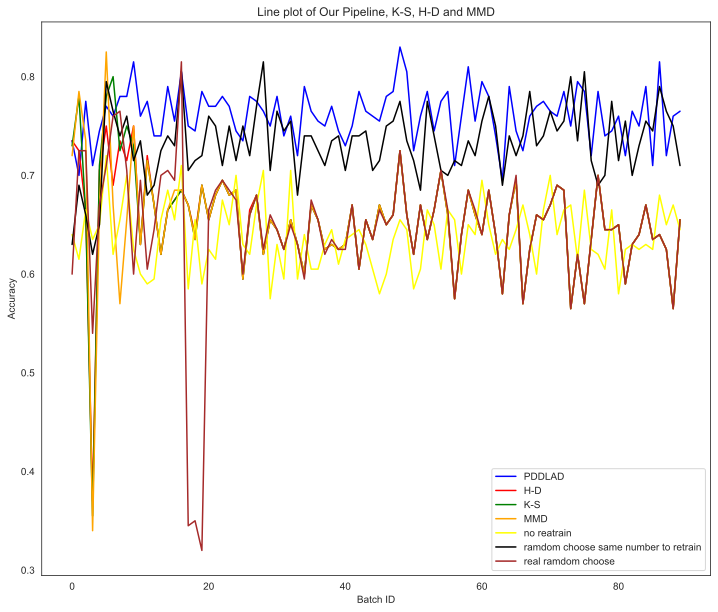

Average Oue methods: 0.7616111111111108
Average KS: 0.6538888888888889
Average MMD: 0.6506111111111111
Average HD: 0.6520555555555556
Average no retrain: 0.6383888888888889
Average ramdom choose retrain: 0.7327222222222222
real ramdom choose retrain: 0.6430555555555557
87


In [365]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
x_axis = list(range(len(list1)))

plt.plot(x_axis, list1, color='blue', label='PDDLAD')
plt.plot(x_axis, list2, color='red', label='H-D')
plt.plot(x_axis, list3, color='green', label='K-S')
plt.plot(x_axis, list4, color='orange', label='MMD')
#plt.plot(x_axis, list5, color='green', label='before retrain HD')
# plt.plot(x_axis, list6, color='orange', label='before reatrain DDLA')
plt.plot(x_axis, list7, color='yellow', label='no reatrain')
plt.plot(x_axis, list5, color='black', label='ramdom choose same number to retrain')
plt.plot(x_axis, list8, color='brown', label='real ramdom choose ')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('Accuracy')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

average_list1 = sum(list1) / len(list1)
print(f"Average Oue methods: {average_list1}")
average_list3 = sum(list3) / len(list3)
print(f"Average KS: {average_list3}")
average_list4 = sum(list4) / len(list4)
print(f"Average MMD: {average_list4}")
average_list2 = sum(list2) / len(list2)
print(f"Average HD: {average_list2}")
average_list7 = sum(list7) / len(list7)
print(f"Average no retrain: {average_list7}")
average_list5 = sum(list5) / len(list5)
print(f"Average ramdom choose retrain: {average_list5}")
average_list8 = sum(list8) / len(list8)
print(f"real ramdom choose retrain: {average_list8}")
count = sum(x > y for x, y in zip(list1, list3))
print(count)

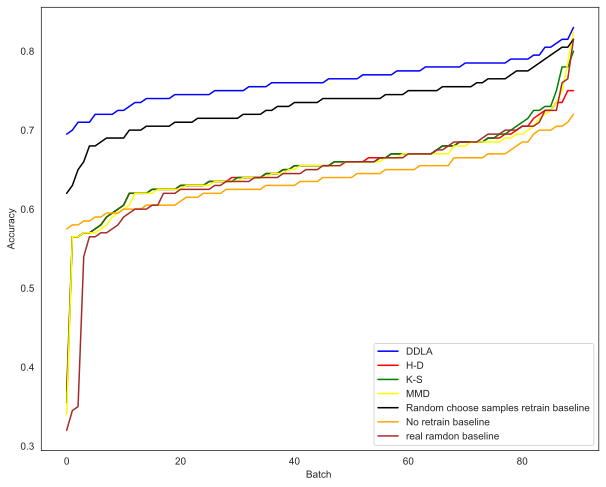

In [366]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(list1)))

plt.plot(x_axis, np.sort(list1), color='blue', label='DDLA')
plt.plot(x_axis, np.sort(list2), color='red', label='H-D')
plt.plot(x_axis, np.sort(list3), color='green', label='K-S')
plt.plot(x_axis, np.sort(list4), color='yellow', label='MMD')
plt.plot(x_axis, np.sort(list5), color='black', label='Random choose samples retrain baseline')
plt.plot(x_axis, np.sort(list7), color='orange', label='No retrain baseline')
plt.plot(x_axis, np.sort(list8), color='brown', label='real ramdon baseline')


plt.legend()

plt.xlabel('Batch ')
plt.ylabel('Accuracy')
#plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

In [355]:
# # 将准确率值分成20个区间
# bins = np.linspace(0.7, 0.95, 21)

# # 计算频率
# hist1, _ = np.histogram(list1, bins=bins, density=True)
# hist2, _ = np.histogram(list3, bins=bins, density=True)

# # 计算累加频率
# cumulative_hist1 = np.cumsum(hist1)
# cumulative_hist2 = np.cumsum(hist2)

# # 绘制曲线图
# plt.plot(cumulative_hist1, bins[:-1], label='PDDLA')
# plt.plot(cumulative_hist2, bins[:-1], label='KS')

# # 添加图例和标签
# plt.legend(loc='lower right')
# plt.xlabel('Cumulative Frequency')
# plt.ylabel('Accuracy')

# # 显示图形
# plt.show()

In [356]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,12))
# x_axis = list(range(len(list1)))
# print(len(list1))
# plt.plot(x_axis, np.sort(list1), color='blue', label='PDDLAD')
# #plt.plot(x_axis, list2, color='red', label='H-D')
# plt.plot(x_axis, np.asarray(list3)[np.argsort(list1)], color='green', label='K-S')
# #plt.plot(x_axis, np.asarray(list4)[np.argsort(list1)], color='orange', label='MMD')
# plt.legend()

# plt.xlabel('Batch ID')
# plt.ylabel('Accuracy')
# plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

# plt.show()


In [357]:
# parameter1 = np.polyfit(x_axis, list1, 10)
# p1 = np.poly1d(parameter1)
# #plt.scatter(x_axis, list1)
# # parameter2 = np.polyfit(x_axis, list2, 10)
# # p2 = np.poly1d(parameter2)
# #plt.scatter(x_axis, list1)
# parameter3 = np.polyfit(x_axis, list3, 10)
# p3 = np.poly1d(parameter3)
# #plt.scatter(x_axis, list1)
# parameter4 = np.polyfit(x_axis, list4, 10)
# p4 = np.poly1d(parameter4)
# #plt.scatter(x_axis, list1)


# plt.plot(x_axis, p1(x_axis), color='blue', label='PDDLAD')
# #plt.plot(x_axis, p2(x_axis), color='red', label='H-D')
# plt.plot(x_axis, p3(x_axis), color='green', label='K-S')
# plt.plot(x_axis, p4(x_axis), color='orange', label='MMD')

# plt.legend()

# plt.xlabel('Batch ID')
# plt.ylabel('Accuracy')
# plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')
# plt.show()

90


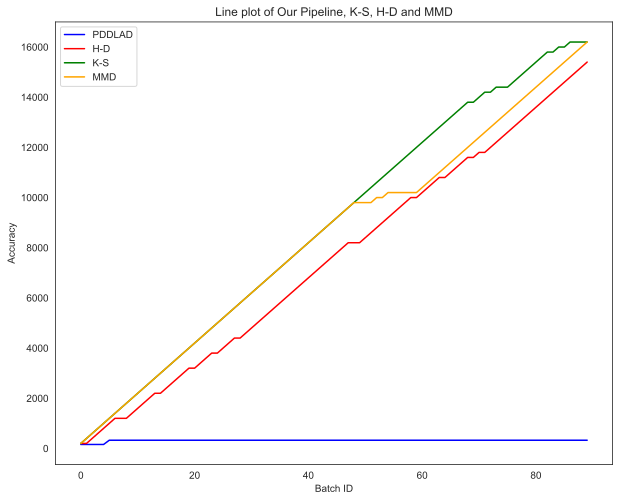

PDDLA the number that expert labeled: 328
KS the number that expert labeled: 16200
HD the number that expert labeled: 15400
MMD the number that expert labeled: 16200


In [358]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(Number_AL)))
# 对x进行累加
print(len(Number_AL))
Number_AL_cumsum = np.cumsum(Number_AL)
Number_AL_KS_cumsum = np.cumsum(Number_AL_KS)
Number_AL_MMD_cumsum = np.cumsum(Number_AL_MMD)
Number_AL_HD_cumsum = np.cumsum(Number_AL_HD)
# print(Number_AL_cumsum.shape)
# print(Number_AL_KS_cumsum)
plt.plot(x_axis, Number_AL_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, Number_AL_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, Number_AL_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, Number_AL_MMD_cumsum, color='orange', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('Accuracy')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()
print(f"PDDLA the number that expert labeled: {Number_AL_cumsum[-1]}")
print(f"KS the number that expert labeled: {Number_AL_KS_cumsum[-1]}")
print(f"HD the number that expert labeled: {Number_AL_HD_cumsum[-1]}")
print(f"MMD the number that expert labeled: {Number_AL_MMD_cumsum[-1]}")

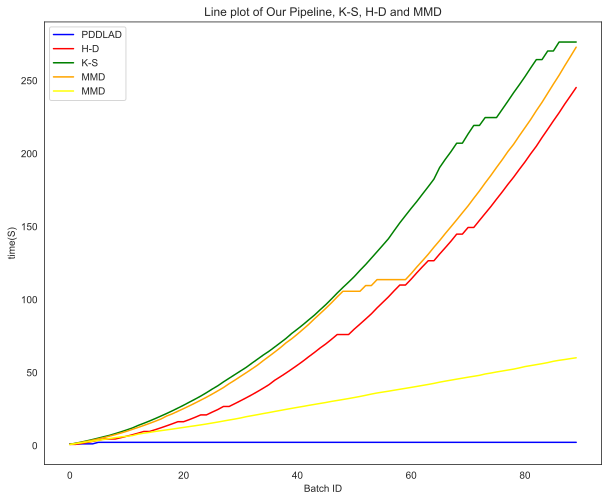

PDDLA retraining time: 2.247591018676758
KS retraining time: 276.43897891044617
MMD retraining time: 272.89517307281494
HD retraining time: 245.25597620010376
real ramdom retraining time: 60.14735388755798


In [370]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
x_axis = list(range(len(trainingtime_list)))
# 对x进行累加
#print(len(Number_AL))
trainingtime_list_cumsum = np.cumsum(trainingtime_list)
trainingtime_list_KS_cumsum = np.cumsum(trainingtime_list_KS)
trainingtime_list_MMD_cumsum = np.cumsum(trainingtime_list_MMD)
trainingtime_list_HD_cumsum = np.cumsum(trainingtime_list_HD)
trainingtime_list_real_random_cumsum = np.cumsum(trainingtime_list_real_random)

plt.plot(x_axis, trainingtime_list_cumsum, color='blue', label='PDDLAD')
plt.plot(x_axis, trainingtime_list_HD_cumsum, color='red', label='H-D')
plt.plot(x_axis, trainingtime_list_KS_cumsum, color='green', label='K-S')
plt.plot(x_axis, trainingtime_list_MMD_cumsum, color='orange', label='MMD')
plt.plot(x_axis, trainingtime_list_real_random_cumsum, color='yellow', label='MMD')
plt.legend()

plt.xlabel('Batch ID')
plt.ylabel('time(S)')
plt.title('Line plot of Our Pipeline, K-S, H-D and MMD')

plt.show()

print(f"PDDLA retraining time: {trainingtime_list_cumsum[-1]}")
print(f"KS retraining time: {trainingtime_list_KS_cumsum[-1]}")
print(f"MMD retraining time: {trainingtime_list_MMD_cumsum[-1]}")
print(f"HD retraining time: {trainingtime_list_HD_cumsum[-1]}")
print(f"real ramdom retraining time: {trainingtime_list_real_random_cumsum[-1]}")